# Overview

In this notebook, I will use the dataset to fine-tune a Resnet18 model with added classification heads for 5 different tasks.

Resnet18 is a fast model that is a good canidate to establish an initial baseline.

In [210]:
%load_ext autoreload
%autoreload 2

RANDOM_STATE = 2025

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [211]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

## Load Data

In [212]:
dataset_dir = "../data/cloth_dataset"
csv_file_name = "aarong_dataset_clean_final.csv"

# Load CSV File
csv_file = os.path.join(dataset_dir, csv_file_name)
df = pd.read_csv(csv_file)

df.sample(3)

,product_id,annotated_image_name,fabric_types_clean,wear_types_clean,colors_clean,textures_clean,value_additions_clean
1351,480,0560000072904.jpg,Cotton,Saree,"purple,green",nakshi,"nakshi,tangail"
2061,6378,1190000011137.jpg,Cotton,Kurta,"red,brown,white","embroidery,printed",NaN
1373,1003,0560000066360_1.jpg___full.png,Cotton,Saree,"grey,golden,green","embroidery,printed",NaN


In [213]:
single_label_features = ['fabric_types_clean', 'wear_types_clean']
multilabel_features = ['colors_clean', 'textures_clean', 'value_additions_clean']

### Pre-Processing

Let's repeat the preprcessing steps to remove NaN values and removing rare labels, as was done in the `training_dataset_review.ipynb` notebook. I will avoid elaborate description for these steps as they are already described in the other notebook.

In [214]:
from my_utils.dataset_utils import remove_rare_labels

for column in single_label_features + multilabel_features:
	# Replace NaN values with empty strings
	df[column] = df[column].fillna('')

	# Remove rare labels
	df[column] = remove_rare_labels(df[column], min_samples_threshold=50)

df.sample(3)

,product_id,annotated_image_name,fabric_types_clean,wear_types_clean,colors_clean,textures_clean,value_additions_clean
2581,7695,0470000103546.jpg,Silk,Scarves,"red,black,white",hand paint,
448,1681,0540000023633_2.jpg,Silk,Saree,"black,blue,white","dye,embroidery,printed",
20,6,0560000072958_2.jpg___dress.png,Cotton,Saree,"orange,purple,golden",,


Now let's encode the feature labels into one-hot format. For the multi-label features, I will use MultiLabelBinarizer from sklearn, which essentially is a one-hot encoding for multiple labels.

I have implemented two utility functions to do the onehot and mlb encoding, to make it easy to reuse, will import and use them for encoding.

In [215]:
from my_utils.preprocessing_utils import ml_binarizer, onehot_encode

for column_name in single_label_features:
	df = onehot_encode(df, column_name)

for column_name in multilabel_features:
	df = ml_binarizer(df, column_name)

df.sample(3)

,product_id,annotated_image_name,fabric_types_clean,wear_types_clean,colors_clean,textures_clean,value_additions_clean,fabric_types_clean__Cotton,fabric_types_clean__Linen,fabric_types_clean__Muslin,...,textures_clean__wax dye,value_additions_clean__,value_additions_clean__applique,value_additions_clean__fringe,value_additions_clean__handloom,value_additions_clean__lace,value_additions_clean__nakshi,value_additions_clean__sequins,value_additions_clean__tangail,value_additions_clean__tassels
2352,7648,0470000103635.jpg,Silk,Scarves,"black,white,green",hand paint,,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
449,7873,0460000029536.jpg,Voile,Nightwear,"pink,white","tie dye,embroidery",,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
3132,7901,0460000029769.jpg___dress.png,Cotton,Nightwear,"black,white","embroidery,floral,printed",lace,1.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0


### Train/Validation/Test Split

At this point, let's create a Train/Validation/Test Split. 70% of the data will be used for training, 15% for validation, and 15% for testing.

In [216]:
from sklearn.model_selection import train_test_split

train_df, val_test_df = train_test_split(df, test_size=0.3, random_state=RANDOM_STATE)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=RANDOM_STATE)


### Data Loader

Now let's create a custom dataset that will use the dataframes above and load respective images.

As a first step, I will define a transform function that will be used to preprocess the images.

In [217]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


Now let's define the custom dataset class. This will identify the one-hot encoded label columns, separately for each feature, based on the column prefix. The images will be loaded based on the image file name available in the dataframe.

In [218]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class CustomMTLDataset(Dataset):
	def __init__(self, df, image_dir, transform=None):
		self.df = df.reset_index(drop=True)
		self.image_dir = image_dir
		self.transform = transform

		# Specifying label groups for each classification head
		self.label_columns = {
			'fabric': [col for col in df.columns if col.startswith('fabric_types_clean__')],
			'wear': [col for col in df.columns if col.startswith('wear_types_clean__')],
			'color': [col for col in df.columns if col.startswith('colors_clean__')],
			'texture': [col for col in df.columns if col.startswith('textures_clean__')],
			'value_add': [col for col in df.columns if col.startswith('value_additions_clean__')],
		}

	def __len__(self):
		return len(self.df)

	def __getitem__(self, idx):
		row = self.df.iloc[idx]
		
		image_path = f"{self.image_dir}/{row['annotated_image_name']}"
		image = Image.open(image_path).convert("RGB")
		
		if self.transform:
			image = self.transform(image)

		# Extract labels for each separate task
		labels = {
			task: torch.tensor(row[self.label_columns[task]].values.astype('float32'))
			for task in self.label_columns
		}

		return image, labels


At this point, let's create the data loader using the custom dataset that was just defined. For now, I will use a batch size of 8 as some labels may have very few samples. Will later experiment with larger batch sizes if make sense.



In [219]:
from torch.utils.data import DataLoader

train_ds = CustomMTLDataset(train_df, os.path.join(dataset_dir, 'images'), transform=transform)
val_ds = CustomMTLDataset(val_df, os.path.join(dataset_dir, 'images'), transform=transform)
test_ds = CustomMTLDataset(test_df, os.path.join(dataset_dir, 'images'), transform=transform)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True) 
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

In [220]:
#train_ds.label_columns['texture']
#train_df['textures_clean__'].value_counts()

## Model Definition

Now time to build the model. I will use a pre-trained ResNet (resnet 18) model and add a single layer for each (task) classification head on top of it.

I would not freeze backbone weights so they should be trained as well, i.e.- fine-tuning as opposed to feature extraction.

In [221]:
import torch.nn as nn
import torchvision.models as models

class MTLModel(nn.Module):
    def __init__(self, fabric_dim, wear_dim, color_dim, texture_dim, value_add_dim):
        super(MTLModel, self).__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone.fc = nn.Identity()
        self.shared_dim = 512  # Output of resnet18 without FC

        self.heads = nn.ModuleDict({
            'fabric': nn.Linear(self.shared_dim, fabric_dim),
            'wear': nn.Linear(self.shared_dim, wear_dim),
            'color': nn.Linear(self.shared_dim, color_dim),
            'texture': nn.Linear(self.shared_dim, texture_dim),
            'value_add': nn.Linear(self.shared_dim, value_add_dim),
        })

    def forward(self, x):
        features = self.backbone(x)
        return {task: head(features) for task, head in self.heads.items()}


## Training Setup

Now let's train the model.

I will use a relatively simple training setup with no learning rate scheduling, class weight consideration or focal loss etc. I will later experiment with these techniques if time permits.

For calculating the training loss, I will use **_binary cross-entropy with logits_** for all tasks, for now. In a later experiment, I will try with separate loss functions for single-label and multi-label tasks.

For evaluation, I will collect the four common metrics (`accuracy`, `precision`, `recall`, `f1`) for all tasks initially. However, in later experiments, I will primarily focus on `F1 score` and `reall` for multi-label tasks, and `accuracy` for single-label tasks.

Update: added per-class metric collection during validation. For that, I also needed to extract class labels for each task ahead of time.

In [222]:
from my_utils.dataset_utils import get_all_labels

task_labels = {
	'fabric': get_all_labels(train_df['fabric_types_clean'], allow_empty=False),
	'wear': get_all_labels(train_df['wear_types_clean'], allow_empty=False),
	'color': get_all_labels(train_df['colors_clean'], allow_empty=False),
	'texture': get_all_labels(train_df['textures_clean'], allow_empty=True),
	'value_add': get_all_labels(train_df['value_additions_clean'], allow_empty=True),
}

for task, labels in task_labels.items():
	print(f"{task}: {len(labels)} labels: {labels}")

fabric: 7 labels: {'Viscose', 'Viscose Blend', 'Linen', 'Voile', 'Silk', 'Cotton', 'Muslin'}
wear: 9 labels: {'Panjabi', 'Scarves', 'Saree', 'Maternity', 'Tops', 'Shalwar Kameez', 'Nightwear', 'Kurta', 'Shawls'}
color: 13 labels: {'brown', 'blue', 'pink', 'white', 'red', 'grey', 'cyan', 'green', 'orange', 'purple', 'black', 'yellow', 'golden'}
texture: 17 labels: {'embroidery', '', 'hand paint', 'dobby', 'striped', 'check', 'brush paint', 'tie dye', 'wax dye', 'dye', 'nakshi', 'applique', 'floral', 'printed', 'block print', 'screen print', 'textured'}
value_add: 9 labels: {'', 'nakshi', 'tangail', 'fringe', 'applique', 'lace', 'sequins', 'tassels', 'handloom'}


In [238]:
import torch
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from tqdm import tqdm
import json
import os

def run_epoch(model, loader, optimizer, device, is_train=True, threshold=0.5):
	if is_train:
		model.train()
	else:
		model.eval()

	total_loss = 0.0
	all_preds = {k: [] for k in model.heads}
	all_targets = {k: [] for k in model.heads}

	for images, labels in tqdm(loader):
		images = images.to(device)
		labels = {k: v.to(device) for k, v in labels.items()}

		if is_train:
			optimizer.zero_grad()

		with torch.set_grad_enabled(is_train):
			outputs = model(images)
			losses = []

			for task in outputs:
				loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs[task], labels[task])
				losses.append(loss)

				if not is_train:
					probs = torch.sigmoid(outputs[task])
					preds = (probs > threshold).int()
					all_preds[task].extend(preds.cpu().numpy())
					all_targets[task].extend(labels[task].cpu().numpy())

			batch_loss = sum(losses)
			total_loss += batch_loss.item()

			if is_train:
				batch_loss.backward()
				optimizer.step()

	avg_loss = total_loss / len(loader)

	if not is_train:
		metrics = {}

		for task in all_preds:
			# Class-wise metrics
			report = classification_report(all_targets[task], all_preds[task], target_names=task_labels[task], output_dict=True, zero_division=0)

			metrics[task] = {
				'f1': f1_score(all_targets[task], all_preds[task], average='micro', zero_division=0),
				'precision': precision_score(all_targets[task], all_preds[task], average='micro', zero_division=0),
				'recall': recall_score(all_targets[task], all_preds[task], average='micro', zero_division=0),
				'accuracy': accuracy_score(all_targets[task], all_preds[task]),

				'classwise_metrics':  {
					class_label : {
						'precision': report[class_label]['precision'],
						'recall': report[class_label]['recall'],
						'f1': report[class_label]['f1-score'],
						'support': report[class_label]['support']
					} for class_label in task_labels[task]
				}
			}

		return avg_loss, metrics

	else:
		return avg_loss


def train_model(model, train_loader, val_loader, optimizer, device, num_epochs=10, threshold=0.5, verbose=True, model_name=''):
	model.to(device)
	best_val_loss = float('inf')
	patience = 3
	patience_counter = 0

	if not model_name:
		model_name = 'unnamed_model_' + pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")

	best_model_path = os.path.join('../data', 'model_weights', f'best_model-{model_name}.pt')
	history_path = os.path.join('../data', 'model_weights', f'history-{model_name}.json')

	history = {
		'train_loss': [],
		'val_loss': [],
		'val_metrics': [],
		'best_epoch': 0
	}

	for epoch in range(num_epochs):
		print(f"\nEpoch {epoch+1}/{num_epochs}")
		train_loss = run_epoch(model, train_loader, optimizer, device, is_train=True)
		val_loss, val_metrics = run_epoch(model, val_loader, optimizer, device, is_train=False, threshold=threshold)

		history['train_loss'].append(train_loss)
		history['val_loss'].append(val_loss)
		history['val_metrics'].append(val_metrics)

		print(f"Train Loss: {train_loss:.4f}")
		print(f"Val Loss: {val_loss:.4f}")

		if verbose:
			for task, task_metrics in val_metrics.items():
				print("Metrics for task:", task)
				for metric_name, metric_value in task_metrics.items():
					print(f"\t[Val {metric_name}]: {metric_value:.4f}")

		# Early stopping
		if val_loss < best_val_loss:
			best_val_loss = val_loss
			patience_counter = 0
			torch.save(model.state_dict(), best_model_path)
			history['best_epoch'] = epoch
		else:
			patience_counter += 1
			if patience_counter >= patience:
				print("Early stopping triggered.")
				break

	# Save the training history
	with open(history_path, 'w') as f:
		json.dump(history, f)

	return history

def evaluate_on_test(model, model_weight_path, test_loader, device, threshold=0.5, verbose=False):
	model.to(device)

	# Load saved weights
	model.load_state_dict(torch.load(model_weight_path, map_location=device))

	with torch.no_grad():
		test_loss, test_metrics = run_epoch(model=model, loader=test_loader, optimizer=None, device=device, is_train=False, threshold=threshold)

	if verbose:
		print(f"\nTest Set Performance:\nTest Loss: {test_loss:.4f}")
		for task, task_metrics in test_metrics.items():
			print(f"\nTask: {task}")
			for metric_name, value in task_metrics.items():
				if metric_name == 'f1':
					print(f"  {metric_name}: {value:.4f}")
			
	test_metric_path = os.path.join('../data', 'model_weights', f'test_metrics-{model_weight_path.split("/")[-1]}.json')

	with open(test_metric_path, 'w') as f:
		json.dump({'test_loss': test_loss, 'test_metrics': test_metrics}, f)
		
	return test_loss, test_metrics

In [164]:
model = MTLModel(
	fabric_dim=len(train_ds.label_columns['fabric']),
	wear_dim=len(train_ds.label_columns['wear']),
	color_dim=len(train_ds.label_columns['color']),
	texture_dim=len(train_ds.label_columns['texture']),
	value_add_dim=len(train_ds.label_columns['value_add']),
)

for param in model.backbone.parameters():
	param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training Run

In [165]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=10,
    threshold=0.5,
	verbose=False,
	model_name='resnet18_baseline'
)



Epoch 1/10


  1%|▏         | 4/289 [00:00<00:16, 16.86it/s]

100%|██████████| 62/62 [00:03<00:00, 17.58it/s]


Train Loss: 1.4465
Val Loss: 1.2910

Epoch 2/10


100%|██████████| 62/62 [00:03<00:00, 17.96it/s]


Train Loss: 1.2907
Val Loss: 1.2456

Epoch 3/10


100%|██████████| 62/62 [00:03<00:00, 17.94it/s]


Train Loss: 1.2249
Val Loss: 1.2731

Epoch 4/10


100%|██████████| 62/62 [00:03<00:00, 17.94it/s]


Train Loss: 1.1765
Val Loss: 1.1605

Epoch 5/10


100%|██████████| 62/62 [00:03<00:00, 17.89it/s]


Train Loss: 1.1187
Val Loss: 1.1632

Epoch 6/10


100%|██████████| 62/62 [00:03<00:00, 17.92it/s]


Train Loss: 1.0610
Val Loss: 1.1245

Epoch 7/10


100%|██████████| 62/62 [00:03<00:00, 17.56it/s]


Train Loss: 1.0151
Val Loss: 1.1116

Epoch 8/10


100%|██████████| 62/62 [00:04<00:00, 15.06it/s]


Train Loss: 0.9672
Val Loss: 1.1477

Epoch 9/10


100%|██████████| 62/62 [00:03<00:00, 17.92it/s]


Train Loss: 0.8959
Val Loss: 1.1261

Epoch 10/10


100%|██████████| 62/62 [00:03<00:00, 17.71it/s]


Train Loss: 0.8208
Val Loss: 1.1531
Early stopping triggered.


## Evaluation

Let's plot the training and validation loss first. And then look at the evaluation metrics for each task.

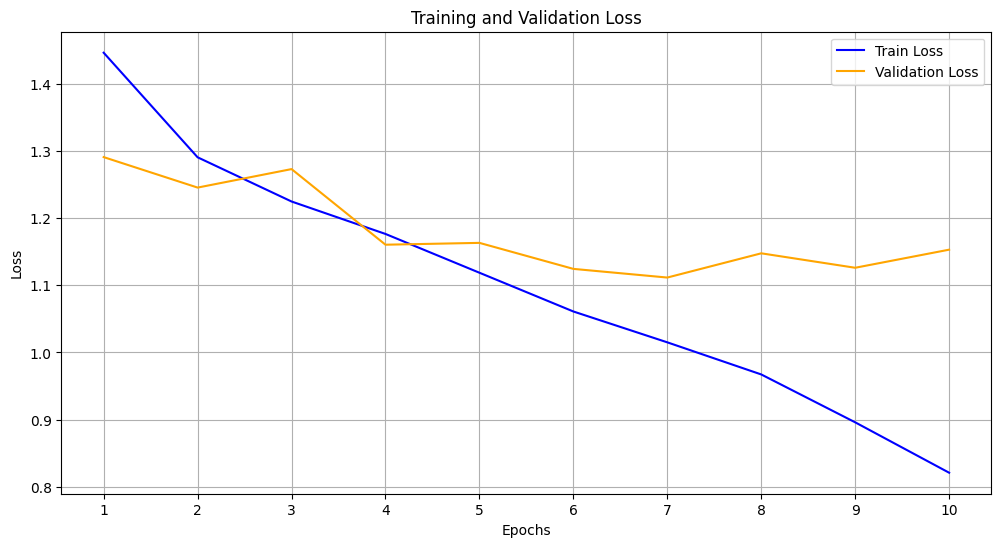

In [166]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.xticks(ticks=range(len(history['train_loss'])), labels=range(1, len(history['train_loss']) + 1))

plt.show()


Looks like model started to overfit after epoch 7. Let's also look at some of the task specific metrics.

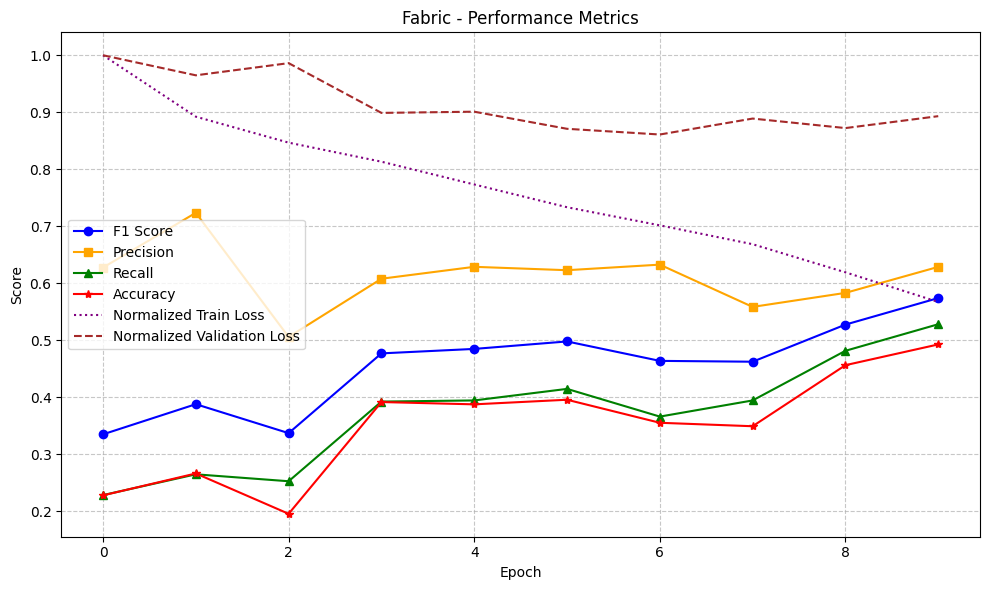

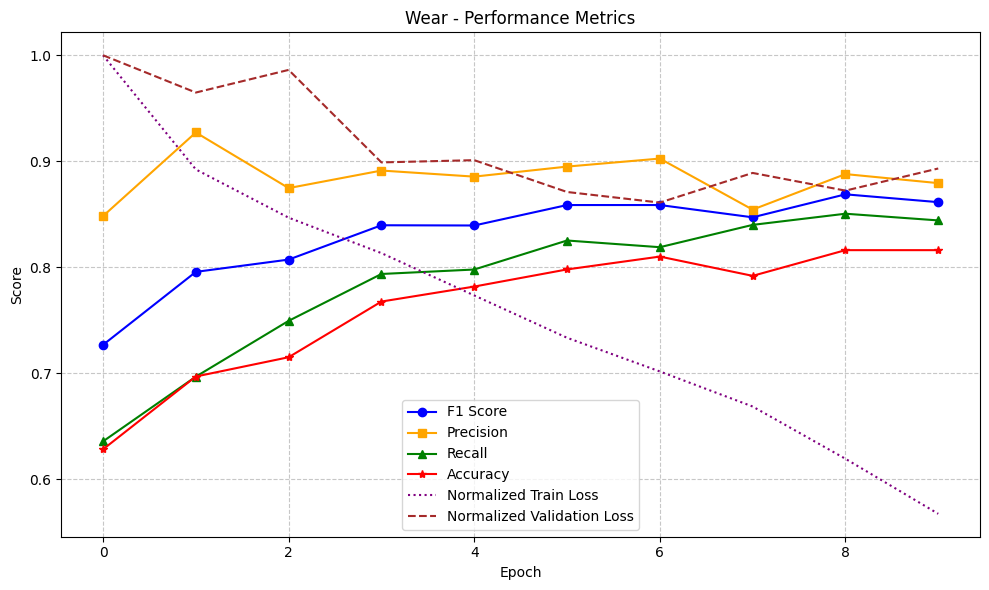

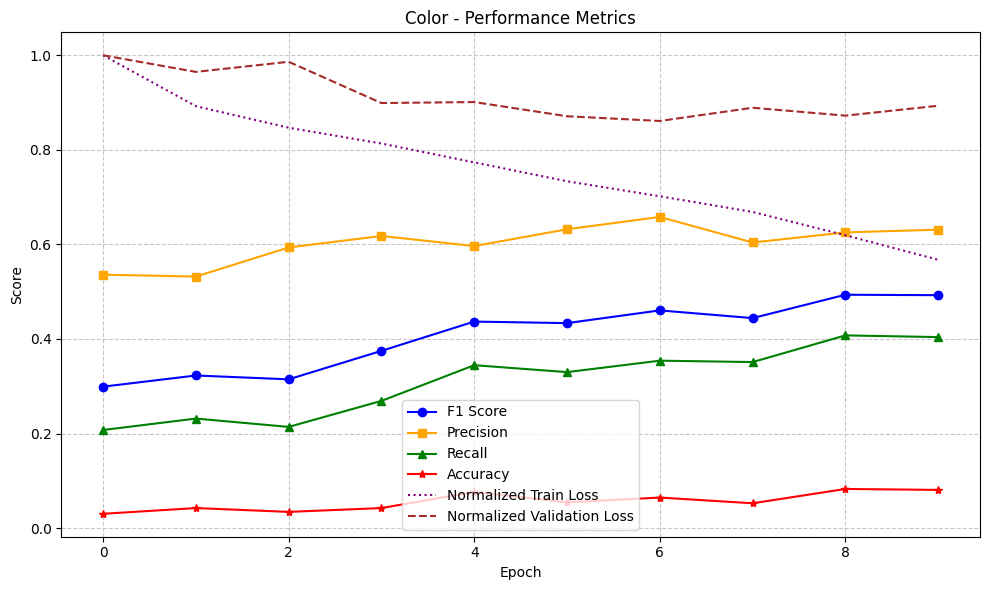

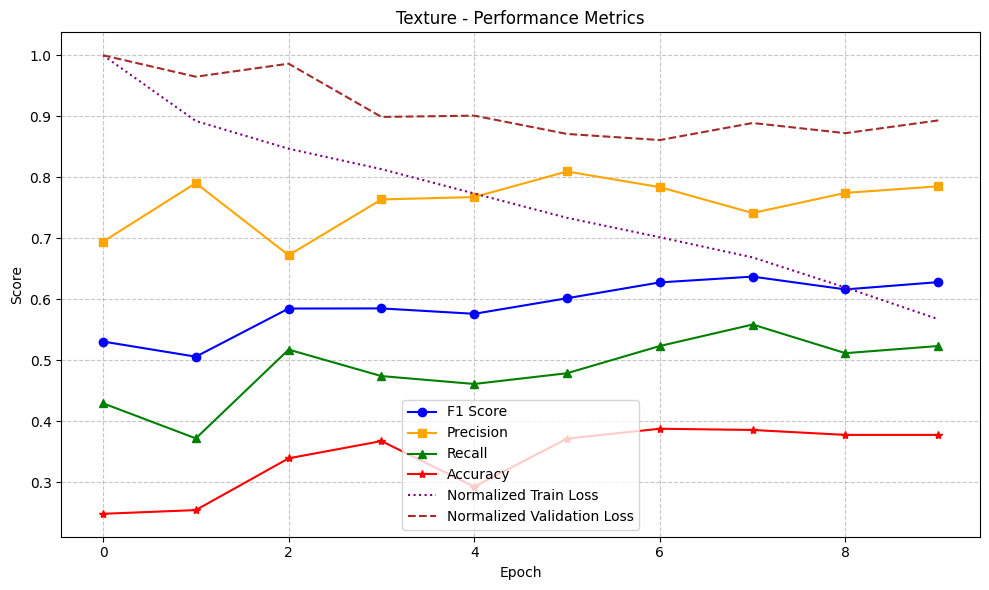

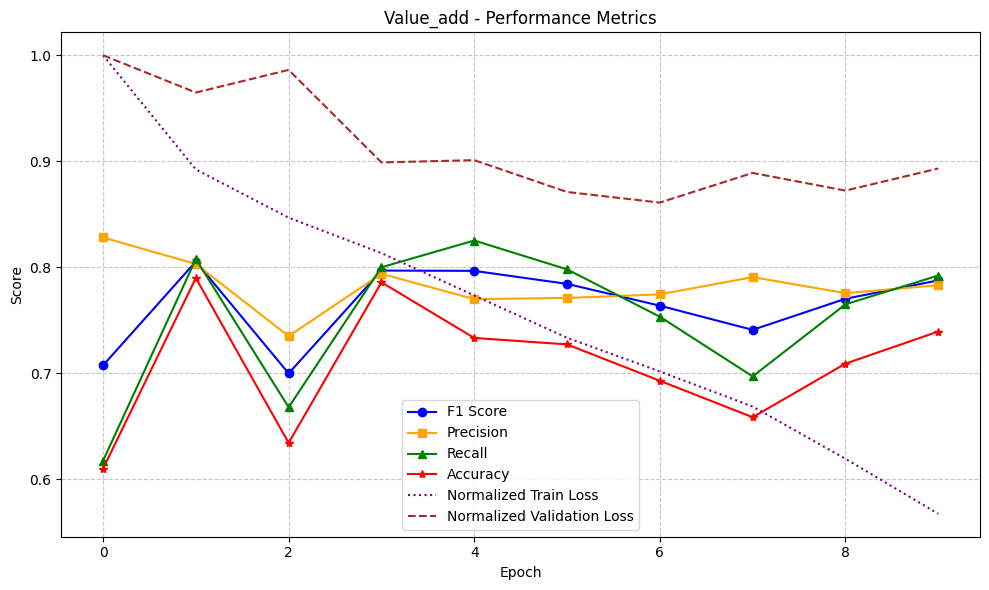

In [167]:
def plot_metrics_for_task(history, task, show_metrics=['f1', 'precision', 'recall', 'accuracy'], show_losses=False):
	# Extract metrics for the specified task
	f1_scores = [epoch_metrics[task]['f1'] for epoch_metrics in history['val_metrics']]
	precision_scores = [epoch_metrics[task]['precision'] for epoch_metrics in history['val_metrics']]
	recall_scores = [epoch_metrics[task]['recall'] for epoch_metrics in history['val_metrics']]
	accuracy_scores = [epoch_metrics[task]['accuracy'] for epoch_metrics in history['val_metrics']]
	
	# Create figure
	plt.figure(figsize=(10, 6))
	
	# Plot the metrics
	if 'f1' in show_metrics:
		plt.plot(f1_scores, label='F1 Score', color='blue', marker='o')
	
	if 'precision' in show_metrics:
		plt.plot(precision_scores, label='Precision', color='orange', marker='s')
	
	if 'recall' in show_metrics:
		plt.plot(recall_scores, label='Recall', color='green', marker='^')
	
	if 'accuracy' in show_metrics:
		plt.plot(accuracy_scores, label='Accuracy', color='red', marker='*')

	if show_losses:
		# Scale into 0,1 range
		rescaled_train_loss = [x / max(history['train_loss']) for x in history['train_loss']]
		rescaled_val_loss = [x / max(history['val_loss']) for x in history['val_loss']]
		
		plt.plot(rescaled_train_loss, label='Normalized Train Loss', color='purple', linestyle=':')
		plt.plot(rescaled_val_loss, label='Normalized Validation Loss', color='brown', linestyle='--')
	
	plt.title(f'{task.capitalize()} - Performance Metrics')
	plt.xlabel('Epoch')
	plt.ylabel('Score')
	plt.legend()
	plt.grid(True, linestyle='--', alpha=0.7)
	plt.tight_layout()
	plt.show()

plot_metrics_for_task(history, 'fabric', show_losses=True)
plot_metrics_for_task(history, 'wear', show_losses=True)
plot_metrics_for_task(history, 'color', show_losses=True)
plot_metrics_for_task(history, 'texture', show_losses=True)
plot_metrics_for_task(history, 'value_add', show_losses=True)

Let's also compare the performance of the tasks against a single metric.

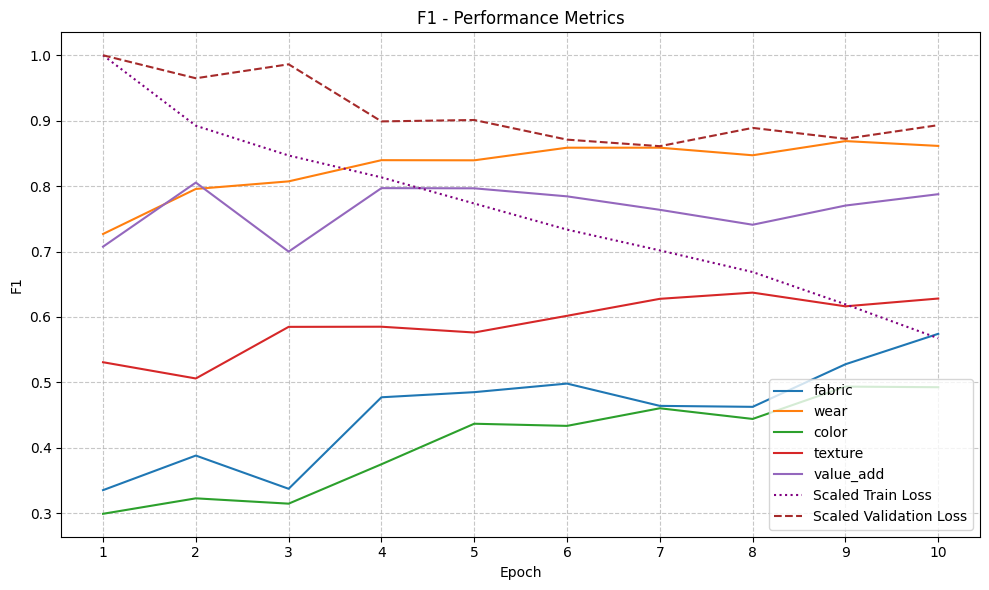

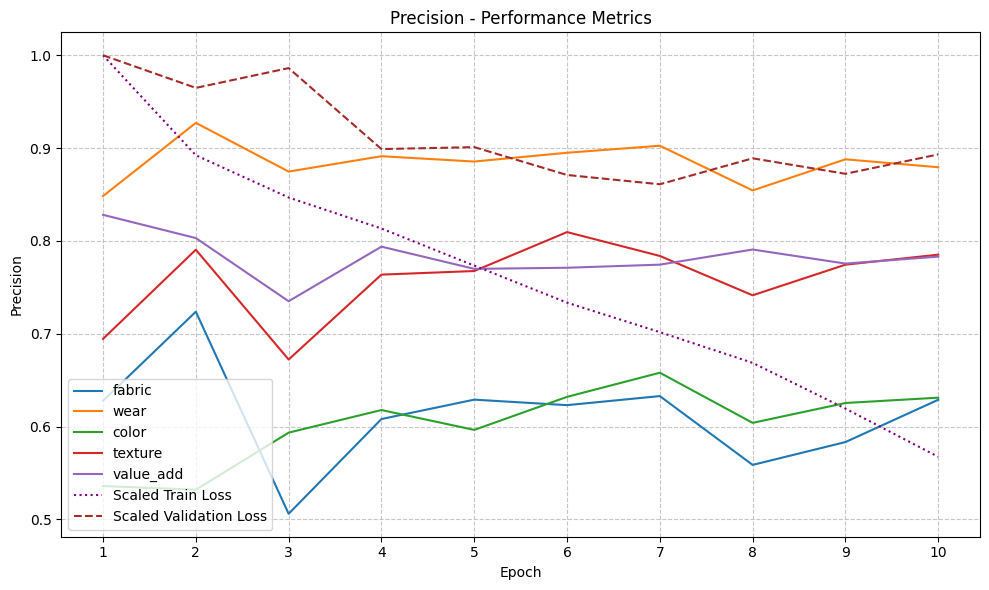

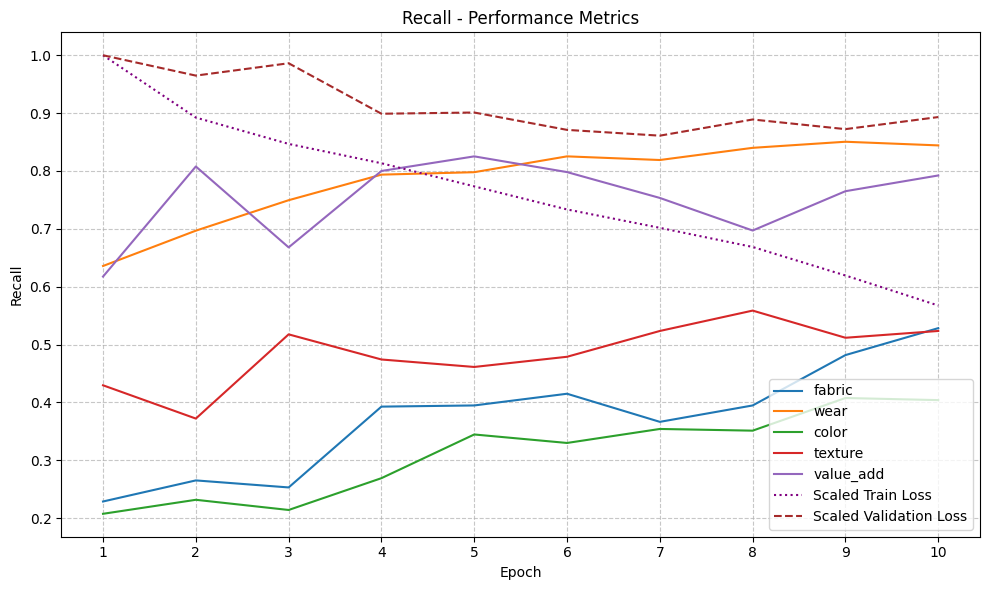

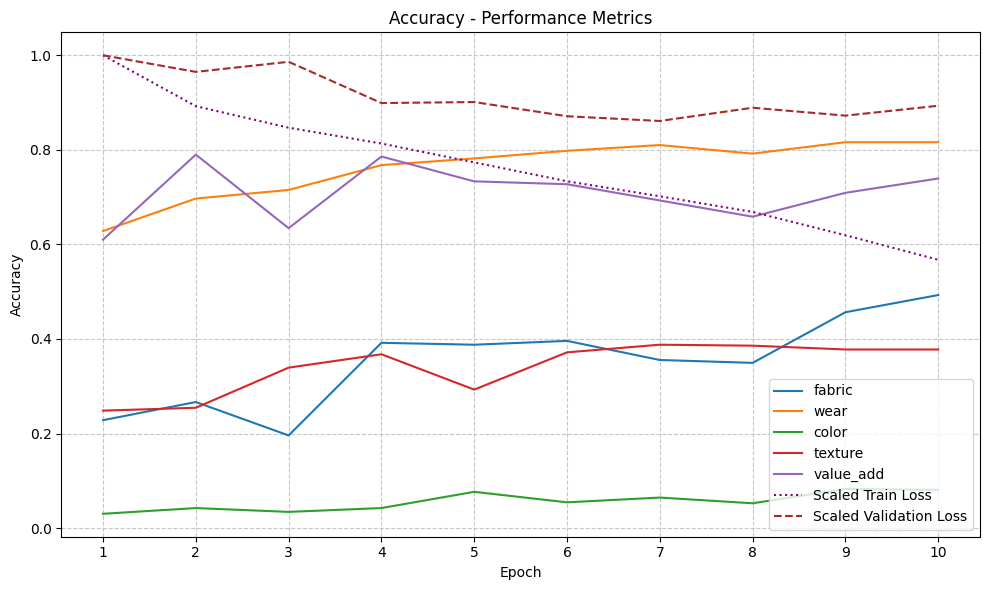

In [168]:
def compare_tasks_for_metric(history, metric_name, show_losses=False):
	plt.figure(figsize=(10, 6))

	tasks = history['val_metrics'][0].keys()

	for task in tasks:
		# Extract specific metric for the task
		metric_scores = [epoch_metrics[task][metric_name] for epoch_metrics in history['val_metrics']]
		plt.plot(metric_scores, label=task)

	if show_losses:
		# Scale into 0,1 range
		rescaled_train_loss = [x / max(history['train_loss']) for x in history['train_loss']]
		rescaled_val_loss = [x / max(history['val_loss']) for x in history['val_loss']]
		
		plt.plot(rescaled_train_loss, label='Scaled Train Loss', color='purple', linestyle=':')
		plt.plot(rescaled_val_loss, label='Scaled Validation Loss', color='brown', linestyle='--')
	
	plt.title(f'{metric_name.capitalize()} - Performance Metrics')
	plt.xlabel('Epoch')
	plt.ylabel(metric_name.capitalize())
	plt.legend()
	plt.grid(True, linestyle='--', alpha=0.7)

	plt.xticks(ticks=range(len(history['train_loss'])), labels=range(1, len(history['train_loss']) + 1))

	plt.tight_layout()
	plt.show()

compare_tasks_for_metric(history, 'f1', show_losses=True)
compare_tasks_for_metric(history, 'precision', show_losses=True)
compare_tasks_for_metric(history, 'recall', show_losses=True)
compare_tasks_for_metric(history, 'accuracy', show_losses=True)

Let's review the metrics of best epoch

In [169]:
best_epoch_index = history['best_epoch']
print(f"Best epoch: Epoch {best_epoch_index + 1}")

metrics = history['val_metrics'][best_epoch_index]

# Separate out classwise_metrics from each task metrics, makes easy to view taskwise metrics
task_metrics = {task: {k: v for k, v in metrics[task].items() if k != 'classwise_metrics'} for task in metrics}
classwise_metrics = {task: metrics[task]['classwise_metrics'] for task in metrics}

pd.DataFrame.from_dict(task_metrics, orient='index').T.round(2)

Best epoch: Epoch 7


,fabric,wear,color,texture,value_add
f1,0.46,0.86,0.46,0.63,0.76
precision,0.63,0.90,0.66,0.78,0.77
recall,0.37,0.82,0.35,0.52,0.75
accuracy,0.36,0.81,0.06,0.39,0.69


Looks like the `wear` and `value addition` did well, and the `color` classification performance seem to be terrible.

Let's review the classwise performance for different tasks, to see which labels are harder to classify. First I will review the F1 and Support for `fabric`, and then do the same for `color`.

In [201]:
def get_classwise_metric(classwise_metrics, task_name, metric_name):
	"""Returns a dictionary of class labels and corresponding metric value."""

	return {class_label: class_metrics[metric_name] for class_label, class_metrics in classwise_metrics[task_name].items()}

get_classwise_metric(classwise_metrics, 'fabric', 'precision')

{'Viscose': 0.6990291262135923,
 'Viscose Blend': 0.0,
 'Linen': 0.3,
 'Voile': 0.9,
 'Silk': 0.6122448979591837,
 'Cotton': 0.45,
 'Muslin': 0.5238095238095238}

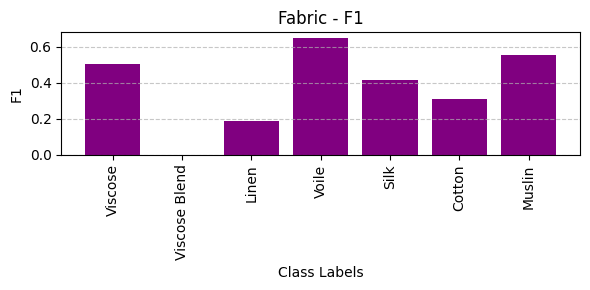

In [205]:
def plot_classwise_metric(classwise_metric, task_name='task', metric_name='metric', color='purple'):
	"""Plots the classwise metric for a given task."""

	plt.figure(figsize=(6, 3))
	plt.bar(classwise_metric.keys(), classwise_metric.values(), color=color)
	plt.title(f'{task_name.capitalize()} - {metric_name.capitalize()}')
	plt.xlabel('Class Labels')
	plt.ylabel(metric_name.capitalize())
	plt.xticks(rotation=90)
	plt.grid(axis='y', linestyle='--', alpha=0.7)
	plt.tight_layout()
	plt.show()

fabric_class_f1 = get_classwise_metric(classwise_metrics, 'fabric', 'f1')
plot_classwise_metric(fabric_class_f1, 'fabric', 'f1')

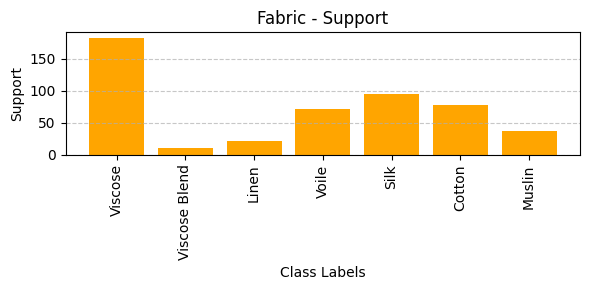

In [207]:
fabric_class_supports = get_classwise_metric(classwise_metrics, 'fabric', 'support')
plot_classwise_metric(fabric_class_supports, 'fabric', 'support', color='orange')

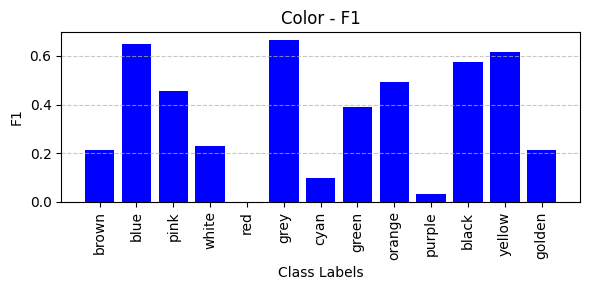

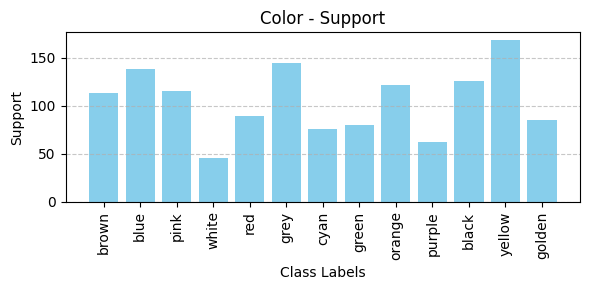

In [209]:
f1_scores = get_classwise_metric(classwise_metrics, 'color', 'f1')
supports = get_classwise_metric(classwise_metrics, 'color', 'support')

plot_classwise_metric(f1_scores, 'color', 'f1', color='blue')
plot_classwise_metric(supports, 'color', 'support', color='skyblue')

So it looks like some of the colors are not being identified at all, such as red, and very low F1 for purple as well, despite havintg a decent amount of samples.

 There could be several reasons behind this, starting with the fact that this is a multi-label task, and each image usually had several colors even including the minor amount of colors in the cloth. Also the color set was reduced down to a limited number of colors through brute generalization rules. Also the threshold may be too high for the color causing it to miss red and most of the purples.

I will experiment with lower threshold, as well as inspect the predicted class label distribution to see which labels are being predicted more often, which might give some idea about what's going on with red.

Finall, let's evaluate on test set.

In [239]:
test_model = MTLModel(
	fabric_dim=len(train_ds.label_columns['fabric']),
	wear_dim=len(train_ds.label_columns['wear']),
	color_dim=len(train_ds.label_columns['color']),
	texture_dim=len(train_ds.label_columns['texture']),
	value_add_dim=len(train_ds.label_columns['value_add']),
)

test_loss, test_metrics = evaluate_on_test(
	model=test_model,
	model_weight_path='../data/model_weights/best_model-resnet18_baseline.pt',
	test_loader=test_loader,
	device=device,
	threshold=0.5
)

  0%|          | 0/62 [00:00<?, ?it/s]

100%|██████████| 62/62 [00:03<00:00, 17.59it/s]


In [240]:
from my_utils.eval_utils import parse_task_metrics_from_test

task_metrics, _ = parse_task_metrics_from_test(test_metrics)

pd.DataFrame.from_dict(task_metrics, orient='index').T.round(2)

,fabric,wear,color,texture,value_add
f1,0.48,0.85,0.48,0.58,0.73
precision,0.64,0.90,0.64,0.75,0.75
recall,0.39,0.80,0.39,0.48,0.70
accuracy,0.38,0.79,0.09,0.35,0.65


This will be used as a **baseline** to compare against the other models in the experiments that follows.

## Conclusion

This is end of initial experiments. Addional experiments will be done in separate notebook so that the experiments are cleaner and easy to follow, most pre-processing and utility functions will be moved to a separate module and reused in the rest of the notebooks.